# Vaccini >70 anni

Strategie di vaccinazione della popolazione a rischio.

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

In [1]:
from itertools import product

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm
from IPython.display import Markdown, Latex, Image

Ci si chiede se sia più efficace vaccinare prima la popolazione a rischio (con maggior tasso di letalità) o prima il resto della popolazione, potendo quest'ultima contenere dei soggetti *superspreaders* con maggior tasso di trasmissione dell'infezione.

***

# Metodo

Si suppone che

- non siano state prese misure di contenimento non farmacologiche (NPI) né siano utilizzati dispositivi di protezione individuale (DPI)
- tutti i singoli soggetti abbiano la medesima probabilità di entrare in contatto con gli altri
- ogni soggetto abbia una propria probabilità di infettare altri soggetti $\mathbf{Pi}$ (che chiameremo "infettività") e una propria probabilità di decesso a priori in seguito ad infezione $\mathbf{Pd}$ (letalità) dipendente dalla macro-categoria di appartenenza
- verranno somministrati vaccini con efficacia $E$ su una percentuale $V$ di popolazione secondo differenti strategie
- l'efficacia $E$ dei vaccini si riferisce indistintamente alla Riduzione del Rischio Relativo ($\mathrm{RRR}$)
    - di infettare
    - di essere infettato
    - di decesso in seguito ad infezione

Si suddividono gli $N$ soggetti della popolazione in tre macro-categorie:

- popolazione generale ($G$)
- popolazione a rischio ($R$)
- popolazione di superspreaders ($S$)

Sarà definita la popolazione a rischio come soggetti maggiori o uguali a 70 anni.

I soggetti $r$ della popolazione a rischio $R$ hanno probabilità di infettare $\mathbf{Pi}$ uguale ai soggetti $g$ popolazione generale $G$ ma probabilità di decesso a priori $\mathbf{Pd}$ maggiore.

I soggetti $s$ della popolazione di superspreaders $S$ hanno probabilità di infettare $\mathbf{Pi}$ maggiore dei soggetti $g$ della popolazione generale $G$ ma medesima probabilità di decesso a priori $\mathbf{Pd}$.

$$
\mathbf{Pi}[R] = \mathbf{Pi}[G]
$$

$$
\mathbf{Pi}[S] > \mathbf{Pi}[G]
$$

$$
\mathbf{Pd}[R] > \mathbf{Pd}[G]
$$

$$
\mathbf{Pd}[S] = \mathbf{Pd}[G]
$$

In assenza di vaccinazione, la probabilità media $\hat{P}[i]$ di ciascun soggetto $i$ di essere infettato sarà pari alla media della probabilità di infettare $\mathrm{Pi}$ degli altri soggetti

$$
\hat{P}[i] = \frac{ \Big( \sum_{n=1}^{N}\mathbf{Pi}[n] \Big) - \mathbf{Pi}[i] }{N-1}
$$

Con vaccinazione di efficacia $E$, la probabilità media $\hat{P}[i]$ di ciascun soggetto $i$ di essere infettato sarà pari alla media della probabilità di infettare $\mathrm{Pi}$ moltiplicata per il complementare dell'efficacia vaccinale $E$ degli altri soggetti

$$
\hat{P}[i] = \big(1-E[i]\big) \frac{ \Big( \sum_{n=1}^{N}\mathbf{Pi}[n] \big(1-E[n]\big) \Big) - \mathbf{Pi}[i]\big(1-E[i]\big) }{N-1}
$$

La probabilità media di essere infettato $\hat{P}$ della popolazione sarà pari alla media delle probabilità di essere infettato dei soggetti

$$
\hat{P} = \frac{\sum_{n=1}^{N}\hat{P}[n]}{N}
$$

La probabilità media di decesso a posteriori $\hat{D}[i]$ di ciascun soggetto $i$ sarà pari alla probabilità media di infettarsi $\hat{P}[i]$ moltiplicata per la probabilità di decesso a priori $\mathbf{Pd}[i]$

$$
\hat{D}[i] = \hat{P}[i] \cdot \mathbf{Pd}[i]
$$

Con vaccinazione di efficacia $E$, la probabilità media di decesso a posteriori $\hat{D}[i]$ di ciascun soggetto $i$ sarà pari alla probabilità media di infettarsi $\hat{P}[i]$ moltiplicata per la probabilità di decesso a priori $\mathbf{Pd}[i]$ e per il complementare dell'efficacia vaccinale

$$
\hat{D}[i] = \hat{P}[i] \cdot \mathbf{Pd}[i] \big(1 - E[i]\big)
$$

La probabilità media di decesso a posteriori $\hat{D}$ della popolazione sarà pari alla media delle probabilità di decesso a posteriori dei soggetti

$$
\hat{D} = \frac{\sum_{n=1}^{N}\hat{D}[n]}{N}
$$

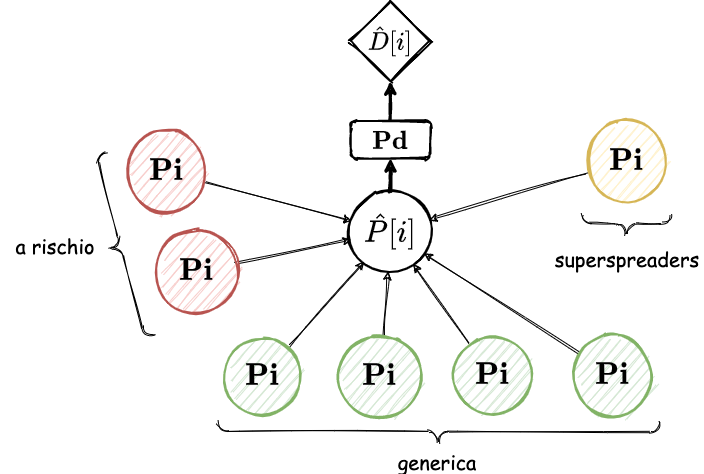

In [2]:
Image('risky_super.png')

> NB: La percentuale di superspreaders e l'infettività di popolazione generale e superspreaders sono state determinate arbitrariamente al fine di massimizzare l'impatto dei superspreaders.

***

# SIMULAZIONE 1

In una popolazione chiusa in cui ciascun soggetto ha pari probabilità di venire in contatto con gli altri e in cui non siano attuate misure di contenimento non farmacologiche, potendo vaccinare solo il $V$ percento della popolazione inferiore alla percentuale di popolazione a rischio e conoscendo

- la letalità nella popolazione non a rischio ($<70$ anni) e nella popolazione a rischio ($\geq70$ anni)
- la percentuale di popolazione a rischio ($\geq70$ anni)

e supponendo

- l’infettività della popolazione generale e della popolazione dei superspreaders
- la percentuale di superspreaders

ci si chiede:

- quale strategia vaccinale minimizza il rischio di contagio inteso come probabilità media di infettarsi?
- quale strategia vaccinale minimizza il rischio di decesso inteso come probabilità media di decesso in seguito ad infezione?

La percentuale della popolazione a rischio ($\geq70$ anni) è definita in base ai dati ISTAT del 1 Gennaio 2020.

La letalità nella popolazione non a rischio ($<70$ anni) e a rischio ($\geq70$ anni) è definita in base ai dati pubblicati dal Dipartimento di Protezione Civile.

Si nota che

- laddove il vaccino copra una sola porzione di popolazione ($\geq70$ o $<70$) il resto della popolazione non è vaccinata
- laddove il vaccino copra l'intera popolazione ($\geq70$ e $<70$) i compartimenti della popolazione sono vaccinati in uguale proporzione

e che

- i superspreaders sono considerati appartenenti alla categoria dei non a rischio ($<70$)

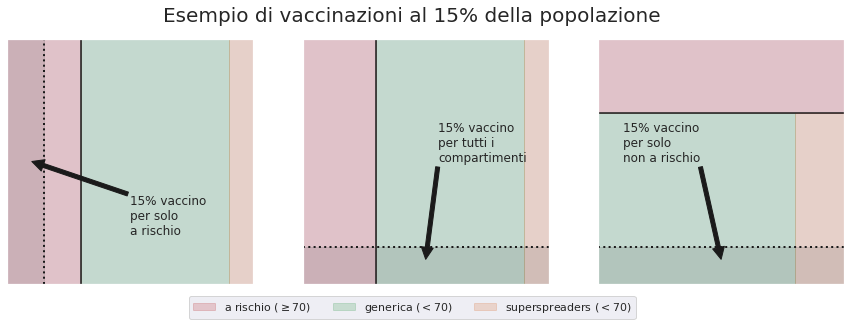

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5), sharex=True, sharey=True)

for axs in ax.flat[:-1]:
    axs.add_patch(Rectangle((0, 0), 3, 10, color='C3', alpha=.25))
    axs.add_patch(Rectangle((3, 0), 6, 10, color='C2', alpha=.25))
    axs.add_patch(Rectangle((9, 0), 1, 10, color='C1', alpha=.25))
    axs.axvline(3, color='k')
    axs.set(
        xlim=(0, 10),
        ylim=(0, 10),
        xticks=[],
        yticks=[],
    )
ax[2].add_patch(Rectangle((0, 7), 10, 3, color='C3', alpha=.25, label='a rischio ($\geq70$)'))
ax[2].add_patch(Rectangle((0, 0), 8, 7, color='C2', alpha=.25, label='generica ($<70$)'))
ax[2].add_patch(Rectangle((8, 0), 2, 7, color='C1', alpha=.25, label='superspreaders ($<70$)'))
ax[2].axhline(7, color='k')
ax[2].set(
    xlim=(0, 10),
    ylim=(0, 10),
    xticks=[],
    yticks=[],
)
    
ax[0].axvline(1.5, color='k', ls=':', lw=2)
ax[0].add_patch(Rectangle((0, 0), 1.5, 10, color='k', alpha=.1))
ax[0].annotate(
    '15% vaccino\nper solo\na rischio',
    xy=(1, 5), xytext=(5, 2),
    arrowprops=dict(color='k')
)
ax[1].axhline(1.5, color='k', ls=':', lw=2)
ax[1].add_patch(Rectangle((0, 0), 10, 1.5, color='k', alpha=.1))
ax[1].annotate(
    '15% vaccino\nper tutti i\ncompartimenti',
    xy=(5, 1), xytext=(5.5, 5),
    arrowprops=dict(color='k')
)
ax[2].axhline(1.5, color='k', ls=':', lw=2)
ax[2].add_patch(Rectangle((0, 0), 10, 1.5, color='k', alpha=.1))
ax[2].annotate(
    '15% vaccino\nper solo\nnon a rischio',
    xy=(5, 1), xytext=(1, 5),
    arrowprops=dict(color='k')
)
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(.5, 0))
fig.suptitle('Esempio di vaccinazioni al 15% della popolazione', fontsize=20)
plt.show()

In [4]:
pop = pd.read_csv('pop_ISTAT.csv')

In [5]:
pop_tot = pop[pop.ETA1=='TOTAL'].Value.values[0]

In [6]:
Y_lo_70 = [f'Y{i}' for i in range(70)]
Y_hi_70 = [f'Y{i}' for i in np.arange(70, 100)]

In [7]:
Y_hi_70.append('Y_GE100')

In [8]:
pop_lo_70 = pop[pop.ETA1.isin(Y_lo_70)].Value.sum()

In [9]:
pop_hi_70 = pop[pop.ETA1.isin(Y_hi_70)].Value.sum()

In [10]:
assert pop_hi_70 + pop_lo_70 == pop_tot

In [11]:
pct_lo_70 = pop_lo_70 / pop_tot
pct_hi_70 = pop_hi_70 / pop_tot

In [12]:
url = "https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx"

In [13]:
sesso_eta = pd.read_excel(
    url,
    sheet_name='sesso_eta',
    parse_dates=['iss_date']
)

In [14]:
sesso_eta.replace('<5', 5, inplace=True)
sesso_eta['DECEDUTI'] = sesso_eta.DECEDUTI.astype(int)
sesso_eta['CASI_CUMULATIVI'] = sesso_eta.CASI_CUMULATIVI.astype(int)

In [15]:
sesso_eta_by_age = sesso_eta.groupby('AGE_GROUP').sum().reset_index()
sesso_eta_by_age['PERCENTUALE'] = sesso_eta_by_age.DECEDUTI / sesso_eta_by_age.CASI_CUMULATIVI

In [16]:
iss_lo_70 = [f'{i*10}-{i*10+9}' for i in range(7)]

In [17]:
iss_hi_70 = ['70-79', '80-89', '>90']

In [18]:
cfr_lo_70 = sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP.isin(iss_lo_70)].PERCENTUALE.mean()

In [19]:
cfr_hi_70 = sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP.isin(iss_hi_70)].PERCENTUALE.mean()

In [20]:
def simulate(N = 1000, VAX_pct = .15, 
             E = [0, .62, .95],
             P_risky = .2, P_super = .05,
             PI_gener = .25, PI_super = .99,
             PD_gener = .02, PD_risky = .2,
             plot = False, Latex = False
            ):

    DF = None
    iterations = len(E)**2
    
    E_prod = product(E, repeat=2)
    E_list = list(E_prod)
    
    for e, E_tuple in enumerate(tqdm(E_list)):
        #print(E_tuple)
        subjects = {
            'strategy': [],
            'category': [],
            'to_die_prior': [],
            'VAX': [],
            'to_infect': [],
            'to_infect_VAX': [],
            'to_be_infected': [],
            'to_die_posterior': [],
        }
        
        E_risky = E_tuple[0]
        E_gener = E_tuple[1]
        N_risky = int(N * P_risky)
        N_super = int(N * P_super)
        N_gener = N - (N_risky + N_super)

        subjects['to_be_infected'] = np.zeros(N)
        subjects['to_die_posterior'] = np.zeros(N)
        subjects['to_infect_VAX'] = np.zeros(N)
        if E_gener == 0 and E_risky == 0:
            subjects['strategy'] = np.repeat(f'nessun vaccino', N)
        elif E_gener == 0:
            subjects['strategy'] = np.repeat(f'>70: {E_risky:.0%}', N)
        elif E_risky == 0:
            subjects['strategy'] = np.repeat(f'<70: {E_gener:.0%}', N)
        else:
            subjects['strategy'] = np.repeat(f'>70: {E_risky:.0%}, <70: {E_gener:.0%}', N)
        
        subjects['category'] = np.concatenate((
            np.repeat('gener', N_gener),
            np.repeat('risky', N_risky),
            np.repeat('super', N_super)
        ))

        subjects['to_infect'] = np.concatenate((
            np.repeat(PI_gener, N_gener),
            np.repeat(PI_gener, N_risky),
            np.repeat(PI_super, N_super)
        ))

        N_vax = int(N * VAX_pct)
        if E_gener == 0 and E_risky == 0:
            yV_risky = 0
            yV_super = 0
            yV_gener = 0
        elif E_gener == 0 and E_risky != 0:
            yV_risky = min(N_risky, N_vax)
            yV_super = 0
            yV_gener = 0
        elif E_gener != 0 and E_risky == 0:
            yV_risky = 0
            yV_super = min(N_super, np.ceil(N_vax * P_super))
            nV_super = N_super - yV_super
            yV_gener = min(N_gener, N_vax - yV_super)
        else:
            yV_risky = min(N_risky, np.ceil(N_vax * P_risky))
            yV_super = min(N_super, np.ceil(N_vax * P_super))
            yV_gener = min(N_gener, N_vax - (yV_risky + yV_super))
        
        nV_gener = N_gener - yV_gener
        nV_super = N_super - yV_super
        nV_risky = N_risky - yV_risky
        #print(yV_gener, yV_risky, yV_super)
        #print(yV1_risky)
        #assert N_risky == yV1_risky + nV1_risky
        
        #print(yV2_super)
        #assert N_super == yV2_super + nV2_super

        #print(yV2_gener)
        #assert N_gener == yV2_gener + nV2_gener

        #assert yV1_risky == yV2_gener + yV2_super

        subjects['VAX'] = np.concatenate((
            subjects['VAX'],
            np.repeat(1, nV_gener), np.repeat((1 - E_gener), yV_gener),
            np.repeat(1, nV_risky), np.repeat((1 - E_risky), yV_risky),
            np.repeat(1, nV_super), np.repeat((1 - E_gener), yV_super),
        ))

        subjects['to_die_prior'] = np.concatenate((
            subjects['to_die_prior'],
            np.repeat(PD_gener, N_gener),
            np.repeat(PD_risky, N_risky),
            np.repeat(PD_gener, N_super)
        ))

        ## integrity test
        for key in tqdm(subjects, leave=False):
            if len(subjects[key]) != N:
                print(key, len(subjects[key]))
                return False

        df = pd.DataFrame(subjects)
        if E_risky == 0 and E_gener == 0:
            assert df.VAX.sum() == N
        else:
            assert df[df.VAX<1].VAX.count() == N_vax

        df['to_infect_VAX'] = df.to_infect * df.VAX

        for idx in tqdm(df.index, leave=False):
            pi = df[df.index!=idx].to_infect_VAX.mean()
            df.loc[df.index==idx, 'to_be_infected'] = pi

        df['to_be_infected'] = df.to_be_infected * df.VAX
        df['to_die_posterior'] = df.to_be_infected * df.to_die_prior * df.VAX
        
        if DF is None:
            DF = df
        else:
            DF = DF.append(df)
    
    if plot:
        
        print('Numero di soggetti:', N)
        print('Efficacia vaccinale pop. a richio:', f"{E_risky:.0%}")
        print('Efficacia vaccinale pop. generale:', f"{E_gener:.0%}")
        print('Percentuale vaccinati', f"{VAX_pct:.0%}")
        pars = pd.DataFrame(
            columns=['generale', 'a rischio', 'superSPR'],
            index=['percentuale', 'infettività', 'prob decesso']
        )
        pars.loc['percentuale', 'generale'] = f"{1 - (P_risky + P_super):.1%}"
        pars.loc['percentuale', 'a rischio'] = f"{P_risky:.1%}"
        pars.loc['percentuale', 'superSPR'] = f"{P_super:.1%}"
        pars.loc['infettività', 'generale'] = f"{PI_gener:.1%}"
        pars.loc['infettività', 'a rischio'] = f"{PI_gener:.1%}"
        pars.loc['infettività', 'superSPR'] = f"{PI_super:.1%}"
        pars.loc['prob decesso', 'generale'] = f"{PD_gener:.1%}"
        pars.loc['prob decesso', 'a rischio'] = f"{PD_risky:.1%}"
        pars.loc['prob decesso', 'superSPR'] = f"{PD_gener:.1%}"
        if Latex:
            display(Markdown(pars.to_latex()))
        else:
            display(Markdown(pars.to_html()))
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        sns.barplot(data=df, y='to_be_infected_VAX0', x='category', ax=ax[0], color='C0')
        sns.barplot(data=df, y='to_be_infected_VAX1', x='category', ax=ax[1], color='C1')
        sns.barplot(data=df, y='to_be_infected_VAX2', x='category', ax=ax[2], color='C2')
        ax[0].set(
            title='none VAX',
            ylabel=None,
        )
        ax[1].set(
            title='risky VAX',
            ylabel=None,
        )
        ax[2].set(
            title='gener VAX',
            ylabel=None,
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        fig.suptitle('Probabilità di infezione per categoria per strategia vaccinale')
        plt.show()
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        sns.barplot(data=df, y='to_die_posterior_VAX0', x='category', ax=ax[0], color='C0')
        sns.barplot(data=df, y='to_die_posterior_VAX1', x='category', ax=ax[1], color='C1')
        sns.barplot(data=df, y='to_die_posterior_VAX2', x='category', ax=ax[2], color='C2')
        ax[0].set(
            title='none VAX',
            ylabel=None,
        )
        ax[1].set(
            title='risky VAX',
            ylabel=None,
        )
        ax[2].set(
            title='gener VAX',
            ylabel=None,
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        fig.suptitle('Probabilità di decesso per categoria per strategia vaccinale')
        plt.show()

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[1].bar(
            ['none VAX', 'risky VAX', 'gener VAX'],
            [
                df.to_die_posterior_VAX0.mean(),
                df.to_die_posterior_VAX1.mean(),
                df.to_die_posterior_VAX2.mean(),
            ],
            color=['C0', 'C1', 'C2']
        )
        ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        ax[1].set(
            title='Probabilità media di decesso',
        )

        ax[0].bar(
            ['none VAX', 'risky VAX', 'gener VAX'],
            [
                df.to_be_infected_VAX0.mean(),
                df.to_be_infected_VAX1.mean(),
                df.to_be_infected_VAX2.mean(),
            ],
            color=['C0', 'C1', 'C2']
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
        ax[0].set(
            title='Probabilità media di infezione',
        )
        plt.show()
    
    return DF

In [21]:
P_super = .01
PI_gener = .05
PI_super = 1
VAX_pct = .15

# uncomment to run and save simulation
_ = """
df = simulate(
    E=[0, .62, .95],
    N=1000, 
    VAX_pct=VAX_pct,
    P_risky=pct_hi_70,
    PD_gener=cfr_lo_70,
    PD_risky=cfr_hi_70,
    PI_gener=PI_gener, PI_super=PI_super,
    plot=False,
    Latex=False)

df.to_csv('pok_simulazione1.csv', index=False)"""

In [22]:
DF1 = pd.read_csv('pok_simulazione1.csv')

In [23]:
DF1_melt = DF1.groupby('strategy').mean().reset_index().sort_values(
    by='to_die_posterior'
).melt(
    id_vars=['strategy']
)

lo_die_idx1 = DF1_melt[DF1_melt.variable=='to_die_posterior'].sort_values(by='value').index[0]
lo_die_str1 = DF1_melt.iloc[lo_die_idx1].strategy
lo_die_val1 = DF1_melt.iloc[lo_die_idx1].value

lo_inf_idx1 = DF1_melt[DF1_melt.variable=='to_be_infected'].sort_values(by='value').index[0]
lo_inf_str1 = DF1_melt.iloc[lo_inf_idx1].strategy
lo_inf_val1 = DF1_melt.iloc[lo_inf_idx1].value

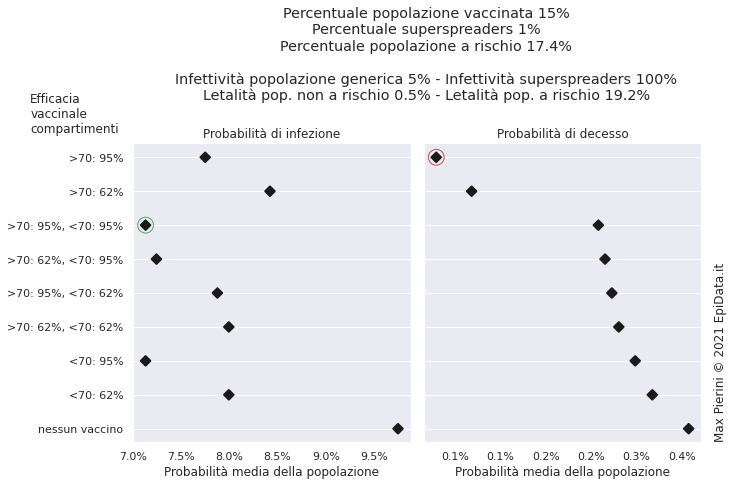

In [24]:
g = sns.catplot(
    kind='point',
    data=DF1_melt[DF1_melt.variable.isin(['to_die_posterior', 'to_be_infected', ])],
    y='strategy', x='value',
    col='variable',
    #palette='Blues',
    color='k', join=False,
    #join=True, lw=1,
    markers=['D'], sizes=20,
    sharex=False,
)
axs = g.axes.flat
axs[0].scatter(lo_inf_val1, 2, marker='o', ec='g', fc='none', s=250)
axs[1].scatter(lo_die_val1, 0, marker='o', ec='r', fc='none', s=250)
for ax in axs:
    ax.grid(alpha=1)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
    ax.set(
        xlabel='Probabilità media della popolazione',
        ylabel=None
    )
    
axs[0].set(
    title='Probabilità di infezione'
)
axs[1].set(
    title='Probabilità di decesso'
)
g.fig.suptitle(
    f'Percentuale popolazione vaccinata {VAX_pct:.0%}\n'
    f'Percentuale superspreaders {P_super:.0%}\n'
    f'Percentuale popolazione a rischio {pct_hi_70:.1%}\n\n'
    f'Infettività popolazione generica {PI_gener:.0%} - Infettività superspreaders {PI_super:.0%}\n'
    f'Letalità pop. non a rischio {cfr_lo_70:.1%} - Letalità pop. a rischio {cfr_hi_70:.1%}\n',
    y=1.3, x=.6
)
g.fig.text(
    .05, .95, 'Efficacia\nvaccinale\ncompartimenti'
)
g.fig.text(
    1, .1, 'Max Pierini © 2021 EpiData.it',
    rotation=90, ha='left'
)
plt.show()

Dai risultati si evidenzia quindi che

In [25]:
Markdown(f"""
- la migliore strategia per la riduzione della probabilità di infezione
è **{lo_inf_str1}**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95% (prob. {lo_inf_val1:.1%})

- la migliore strategia per la riduzione della probabilità di decesso
è **{lo_die_str1}**, ovvero la vaccinazione della popolazione a rischio con vaccino di
efficacia 95% (prob. {lo_die_val1:.2%})
""")


- la migliore strategia per la riduzione della probabilità di infezione
è **>70: 95%, <70: 95%**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95% (prob. 7.1%)

- la migliore strategia per la riduzione della probabilità di decesso
è **>70: 95%**, ovvero la vaccinazione della popolazione a rischio con vaccino di
efficacia 95% (prob. 0.08%)


# SIMULAZIONE 2

In una popolazione chiusa in cui ciascun soggetto ha pari probabilità di venire in contatto con gli altri e in cui non siano attuate misure di contenimento non farmacologiche, potendo vaccinare solo dal $V_0$ a al $V_n$ percento della popolazione inferiore alla percentuale di popolazione a rischio e conoscendo

- la letalità nella popolazione non a rischio ($<70$ anni) e nella popolazione a rischio ($\geq70$ anni)
- la percentuale di popolazione a rischio ($\geq70$ anni)

e supponendo

- l’infettività della popolazione generale e della popolazione dei superspreaders
- la percentuale di superspreaders

ci si chiede:

- quale strategia vaccinale minimizza il rischio di contagio inteso come probabilità media di infettarsi?
- quale strategia vaccinale minimizza il rischio di decesso inteso come probabilità media di decesso in seguito ad infezione?

La percentuale della popolazione a rischio ($\geq70$ anni) è definita in base ai dati ISTAT del 1 Gennaio 2020.

La letalità nella popolazione non a rischio ($<70$ anni) e a rischio ($\geq70$ anni) è definita in base ai dati pubblicati dal Dipartimento di Protezione Civile.

Si nota che

- laddove il vaccino copra una sola porzione di popolazione ($\geq70$ o $<70$) il resto della popolazione non è vaccinata
- laddove il vaccino copra l'intera popolazione ($\geq70$ e $<70$) i compartimenti della popolazione sono vaccinati in uguale proporzione

e che

- i superspreaders sono considerati appartenenti alla categoria dei non a rischio ($<70$)

In [26]:
# uncomment to run and save simulation
_ = """
DF = None

for VAX_pct in [.01, .05, .1, .15]:
    P_super = .01
    PI_gener = .05
    PI_super = 1

    df = simulate(
        E=[0, .62, .95],
        N=1000, 
        VAX_pct=VAX_pct,
        P_risky=pct_hi_70,
        PD_gener=cfr_lo_70,
        PD_risky=cfr_hi_70,
        PI_gener=PI_gener, PI_super=PI_super,
        plot=False,
        Latex=False)
    df['vaccinati'] = f"{VAX_pct:.0%}"
    if DF is None:
        DF = df
    else:
        DF = DF.append(df, ignore_index=True)

DF.to_csv('pok_simulazione2.csv', index=False)"""

In [27]:
DF2 = pd.read_csv('pok_simulazione2.csv')

In [28]:
DF2_grouped = DF2.groupby(['vaccinati', 'strategy']).mean().reset_index()

DF2_melt = DF2_grouped.sort_values(
    by='to_die_posterior'
).melt(
    id_vars=['vaccinati', 'strategy']
)

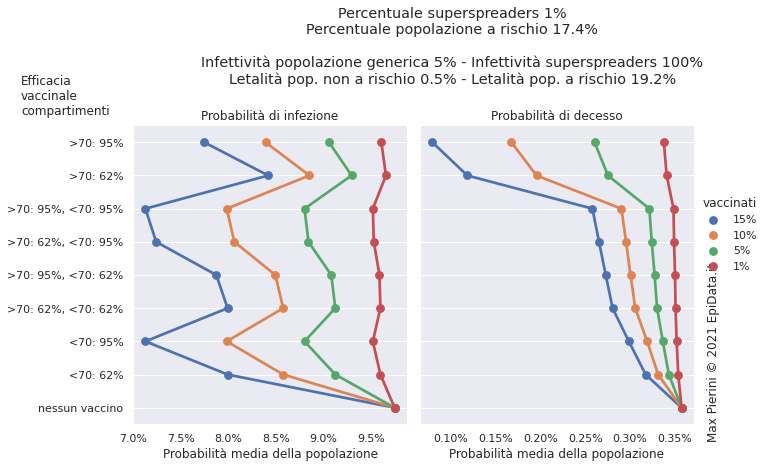

In [29]:
g = sns.catplot(
    kind='point',
    data=DF2_melt[DF2_melt.variable.isin(['to_die_posterior', 'to_be_infected', ])],
    y='strategy', x='value',
    col='variable', hue='vaccinati',
    #palette='Blues',
    #color='k', 
    join=True,
    #join=True, lw=1,
    #markers=['D'], sizes=20,
    sharex=False,
)
axs = g.axes.flat
#axs[0].scatter(lo_inf_val, 2, marker='o', ec='g', fc='none', s=250)
#axs[1].scatter(lo_die_val, 0, marker='o', ec='r', fc='none', s=250)
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
for ax in axs:
    ax.grid(alpha=1)
    ax.set(
        xlabel='Probabilità media della popolazione',
        ylabel=None
    )
    
axs[0].set(
    title='Probabilità di infezione'
)
axs[1].set(
    title='Probabilità di decesso'
)
g.fig.suptitle(
    f'Percentuale superspreaders {P_super:.0%}\n'
    f'Percentuale popolazione a rischio {pct_hi_70:.1%}\n\n'
    f'Infettività popolazione generica {PI_gener:.0%} - Infettività superspreaders {PI_super:.0%}\n'
    f'Letalità pop. non a rischio {cfr_lo_70:.1%} - Letalità pop. a rischio {cfr_hi_70:.1%}\n',
    y=1.25, x=.6
)
g.fig.text(
    .05, .95, 'Efficacia\nvaccinale\ncompartimenti'
)
g.fig.text(
    .925, .05, 'Max Pierini © 2021 EpiData.it',
    rotation=90, ha='left'
)
plt.show()

In [30]:
Markdown(f"""
- la migliore strategia per la riduzione della probabilità di infezione
è **{lo_inf_str1}**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%
""")


- la migliore strategia per la riduzione della probabilità di infezione
è **>70: 95%, <70: 95%**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%


In [31]:
for vaccinati in DF2_melt.vaccinati.unique():
    _idx = DF2_melt[
        (DF2_melt.variable=='to_be_infected')
        &
        (DF2_melt.vaccinati==vaccinati)
    ].sort_values(by='value').index.values[0]
    _vax = DF2_melt.iloc[_idx].vaccinati
    _str = DF2_melt.iloc[_idx].strategy
    _val = DF2_melt.iloc[_idx].value
    print('vaccinazione', _vax, ', prob.', f"{_val:.1%}")

vaccinazione 15% , prob. 7.1%
vaccinazione 10% , prob. 8.0%
vaccinazione 5% , prob. 8.8%
vaccinazione 1% , prob. 9.5%


In [32]:
Markdown(f"""
- la migliore strategia per la riduzione della probabilità di decesso
è **{lo_die_str1}**, ovvero la vaccinazione della popolazione a rischio con vaccino di
efficacia 95%
""")


- la migliore strategia per la riduzione della probabilità di decesso
è **>70: 95%**, ovvero la vaccinazione della popolazione a rischio con vaccino di
efficacia 95%


In [33]:
for vaccinati in DF2_melt.vaccinati.unique():
    _idx = DF2_melt[
        (DF2_melt.variable=='to_die_posterior')
        &
        (DF2_melt.vaccinati==vaccinati)
    ].sort_values(by='value').index.values[0]
    _vax = DF2_melt.iloc[_idx].vaccinati
    _str = DF2_melt.iloc[_idx].strategy
    _val = DF2_melt.iloc[_idx].value
    print('vaccinazione', _vax, ', prob.', f"{_val:.2%}")

vaccinazione 15% , prob. 0.08%
vaccinazione 10% , prob. 0.17%
vaccinazione 5% , prob. 0.26%
vaccinazione 1% , prob. 0.34%


# SIMULAZIONE 3

In una popolazione chiusa in cui ciascun soggetto ha pari probabilità di venire in contatto con gli altri e in cui non siano attuate misure di contenimento non farmacologiche, potendo vaccinare solo dal $V_0$ al $V_n$ percento della popolazione superiore alla percentuale di popolazione a rischio, considerando questa verrebbe comunque vaccinata interamente, e conoscendo

- la letalità nella popolazione non a rischio ($<70$ anni) e nella popolazione a rischio ($\geq70$ anni)
- la percentuale di popolazione a rischio ($\geq70$ anni)
e supponendo
- l’infettività della popolazione generale e della popolazione dei superspreaders
- la percentuale di superspreaders

ci si chiede:

- quale strategia vaccinale minimizza il rischio di contagio inteso come probabilità media di infettarsi?
- quale strategia vaccinale minimizza il rischio di decesso inteso come probabilità media di decesso in seguito ad infezione?

La percentuale della popolazione a rischio ($\geq70$ anni) è definita in base ai dati ISTAT del 1 Gennaio 2020.

La letalità nella popolazione non a rischio ($<70$ anni) e a rischio ($\geq70$ anni) è definita in base ai dati pubblicati dal Dipartimento di Protezione Civile.

Si nota che

- coprendo il vaccino l'intera popolazione ($\geq70$ e $<70$) i compartimenti della popolazione sono vaccinati in uguale proporzione

e che

- i superspreaders sono considerati appartenenti alla categoria dei non a rischio ($<70$)

In [34]:
def simulate2(N = 1000, VAX_pct = .15, 
              E = [0, .62, .95],
              P_risky = .2, P_super = .05,
              PI_gener = .25, PI_super = .99,
              PD_gener = .02, PD_risky = .2,
              plot = False, Latex = False
             ):

    DF = None
    iterations = len(E)**2
    
    E_prod = product(E, repeat=2)
    E_list = list(E_prod)
    
    for e, E_tuple in enumerate(tqdm(E_list)):
        #print(E_tuple)
        subjects = {
            'strategy': [],
            'category': [],
            'to_die_prior': [],
            'VAX': [],
            'to_infect': [],
            'to_infect_VAX': [],
            'to_be_infected': [],
            'to_die_posterior': [],
        }
        
        E_risky = E_tuple[0]
        E_gener = E_tuple[1]
        N_risky = int(N * P_risky)
        N_super = int(N * P_super)
        N_gener = N - (N_risky + N_super)

        subjects['to_be_infected'] = np.zeros(N)
        subjects['to_die_posterior'] = np.zeros(N)
        subjects['to_infect_VAX'] = np.zeros(N)
        if E_gener == 0 and E_risky == 0:
            continue
            subjects['strategy'] = np.repeat(f'nessun vaccino', N)
        elif E_gener == 0:
            continue
            subjects['strategy'] = np.repeat(f'>70: {E_risky:.0%}', N)
        elif E_risky == 0:
            continue
            subjects['strategy'] = np.repeat(f'<70: {E_gener:.0%}', N)
        else:
            subjects['strategy'] = np.repeat(f'>70: {E_risky:.0%}, <70: {E_gener:.0%}', N)
        
        subjects['category'] = np.concatenate((
            np.repeat('gener', N_gener),
            np.repeat('risky', N_risky),
            np.repeat('super', N_super)
        ))

        subjects['to_infect'] = np.concatenate((
            np.repeat(PI_gener, N_gener),
            np.repeat(PI_gener, N_risky),
            np.repeat(PI_super, N_super)
        ))

        N_vax = int(N * VAX_pct)
        if E_gener == 0 and E_risky == 0:
            continue
        elif E_gener == 0 and E_risky != 0:
            continue
        elif E_gener != 0 and E_risky == 0:
            continue
        else:
            yV_risky = N_risky
            N_va_s_g = N_vax - yV_risky
            yV_super = min(N_super, np.ceil(N_va_s_g * P_super))
            yV_gener = min(N_gener, N_va_s_g - yV_super)
        
        nV_gener = N_gener - yV_gener
        nV_super = N_super - yV_super
        nV_risky = N_risky - yV_risky
        #print(yV_gener, yV_risky, yV_super)
        #print(yV1_risky)
        #assert N_risky == yV1_risky + nV1_risky
        
        #print(yV2_super)
        #assert N_super == yV2_super + nV2_super

        #print(yV2_gener)
        #assert N_gener == yV2_gener + nV2_gener

        #assert yV1_risky == yV2_gener + yV2_super

        subjects['VAX'] = np.concatenate((
            subjects['VAX'],
            np.repeat(1, nV_gener), np.repeat((1 - E_gener), yV_gener),
            np.repeat(1, nV_risky), np.repeat((1 - E_risky), yV_risky),
            np.repeat(1, nV_super), np.repeat((1 - E_gener), yV_super),
        ))

        subjects['to_die_prior'] = np.concatenate((
            subjects['to_die_prior'],
            np.repeat(PD_gener, N_gener),
            np.repeat(PD_risky, N_risky),
            np.repeat(PD_gener, N_super)
        ))

        ## integrity test
        for key in tqdm(subjects, leave=False):
            if len(subjects[key]) != N:
                print(key, len(subjects[key]))
                return False

        df = pd.DataFrame(subjects)
        if E_risky == 0 and E_gener == 0:
            assert df.VAX.sum() == N
        else:
            assert df[df.VAX<1].VAX.count() == N_vax

        df['to_infect_VAX'] = df.to_infect * df.VAX

        for idx in tqdm(df.index, leave=False):
            pi = df[df.index!=idx].to_infect_VAX.mean()
            df.loc[df.index==idx, 'to_be_infected'] = pi

        df['to_be_infected'] = df.to_be_infected * df.VAX
        df['to_die_posterior'] = df.to_be_infected * df.to_die_prior * df.VAX
        
        if DF is None:
            DF = df
        else:
            DF = DF.append(df)
    
    if plot:
        
        print('Numero di soggetti:', N)
        print('Efficacia vaccinale pop. a richio:', f"{E_risky:.0%}")
        print('Efficacia vaccinale pop. generale:', f"{E_gener:.0%}")
        print('Percentuale vaccinati', f"{VAX_pct:.0%}")
        pars = pd.DataFrame(
            columns=['generale', 'a rischio', 'superSPR'],
            index=['percentuale', 'infettività', 'prob decesso']
        )
        pars.loc['percentuale', 'generale'] = f"{1 - (P_risky + P_super):.1%}"
        pars.loc['percentuale', 'a rischio'] = f"{P_risky:.1%}"
        pars.loc['percentuale', 'superSPR'] = f"{P_super:.1%}"
        pars.loc['infettività', 'generale'] = f"{PI_gener:.1%}"
        pars.loc['infettività', 'a rischio'] = f"{PI_gener:.1%}"
        pars.loc['infettività', 'superSPR'] = f"{PI_super:.1%}"
        pars.loc['prob decesso', 'generale'] = f"{PD_gener:.1%}"
        pars.loc['prob decesso', 'a rischio'] = f"{PD_risky:.1%}"
        pars.loc['prob decesso', 'superSPR'] = f"{PD_gener:.1%}"
        if Latex:
            display(Markdown(pars.to_latex()))
        else:
            display(Markdown(pars.to_html()))
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        sns.barplot(data=df, y='to_be_infected_VAX0', x='category', ax=ax[0], color='C0')
        sns.barplot(data=df, y='to_be_infected_VAX1', x='category', ax=ax[1], color='C1')
        sns.barplot(data=df, y='to_be_infected_VAX2', x='category', ax=ax[2], color='C2')
        ax[0].set(
            title='none VAX',
            ylabel=None,
        )
        ax[1].set(
            title='risky VAX',
            ylabel=None,
        )
        ax[2].set(
            title='gener VAX',
            ylabel=None,
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        fig.suptitle('Probabilità di infezione per categoria per strategia vaccinale')
        plt.show()
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        sns.barplot(data=df, y='to_die_posterior_VAX0', x='category', ax=ax[0], color='C0')
        sns.barplot(data=df, y='to_die_posterior_VAX1', x='category', ax=ax[1], color='C1')
        sns.barplot(data=df, y='to_die_posterior_VAX2', x='category', ax=ax[2], color='C2')
        ax[0].set(
            title='none VAX',
            ylabel=None,
        )
        ax[1].set(
            title='risky VAX',
            ylabel=None,
        )
        ax[2].set(
            title='gener VAX',
            ylabel=None,
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        fig.suptitle('Probabilità di decesso per categoria per strategia vaccinale')
        plt.show()

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[1].bar(
            ['none VAX', 'risky VAX', 'gener VAX'],
            [
                df.to_die_posterior_VAX0.mean(),
                df.to_die_posterior_VAX1.mean(),
                df.to_die_posterior_VAX2.mean(),
            ],
            color=['C0', 'C1', 'C2']
        )
        ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
        ax[1].set(
            title='Probabilità media di decesso',
        )

        ax[0].bar(
            ['none VAX', 'risky VAX', 'gener VAX'],
            [
                df.to_be_infected_VAX0.mean(),
                df.to_be_infected_VAX1.mean(),
                df.to_be_infected_VAX2.mean(),
            ],
            color=['C0', 'C1', 'C2']
        )
        ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
        ax[0].set(
            title='Probabilità media di infezione',
        )
        plt.show()
    
    return DF

In [35]:
# uncomment to run and save simulation
_ = """
DF = None

for VAX_pct in [.25, .5, .75, .95]:
    P_super = .01
    PI_gener = .05
    PI_super = 1

    df = simulate2(
        E=[0, .62, .95],
        N=1000, 
        VAX_pct=VAX_pct,
        P_risky=pct_hi_70,
        PD_gener=cfr_lo_70,
        PD_risky=cfr_hi_70,
        PI_gener=PI_gener, PI_super=PI_super,
        plot=False,
        Latex=False)
    df['vaccinati'] = f"{VAX_pct:.0%}"
    if DF is None:
        DF = df
    else:
        DF = DF.append(df, ignore_index=True)
        
DF.to_csv('pok_simulazione3.csv', index=False)"""

In [36]:
DF3 = pd.read_csv('pok_simulazione3.csv')

In [37]:
DF3_grouped = DF3.groupby(['vaccinati', 'strategy']).mean().reset_index()

DF3_melt = DF3_grouped.sort_values(
    by='to_die_posterior'
).melt(
    id_vars=['vaccinati', 'strategy']
)

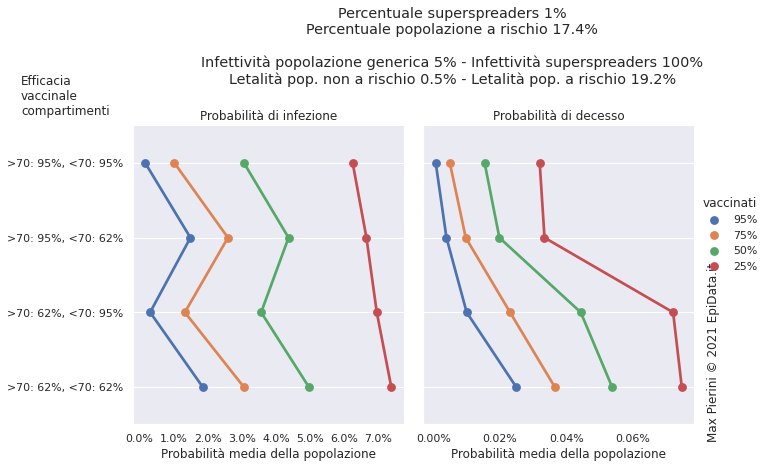

In [38]:
g = sns.catplot(
    kind='point',
    data=DF3_melt[DF3_melt.variable.isin(['to_die_posterior', 'to_be_infected', ])],
    y='strategy', x='value',
    col='variable', hue='vaccinati',
    #palette='Blues',
    #color='k', 
    join=True,
    #join=True, lw=1,
    #markers=['D'], sizes=20,
    sharex=False,
)
axs = g.axes.flat
#axs[0].scatter(lo_inf_val, 2, marker='o', ec='g', fc='none', s=250)
#axs[1].scatter(lo_die_val, 0, marker='o', ec='r', fc='none', s=250)
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
for ax in axs:
    ax.grid(alpha=1)
    ax.set(
        xlabel='Probabilità media della popolazione',
        ylabel=None
    )
    
axs[0].set(
    title='Probabilità di infezione'
)
axs[1].set(
    title='Probabilità di decesso'
)
g.fig.suptitle(
    f'Percentuale superspreaders {P_super:.0%}\n'
    f'Percentuale popolazione a rischio {pct_hi_70:.1%}\n\n'
    f'Infettività popolazione generica {PI_gener:.0%} - Infettività superspreaders {PI_super:.0%}\n'
    f'Letalità pop. non a rischio {cfr_lo_70:.1%} - Letalità pop. a rischio {cfr_hi_70:.1%}\n',
    y=1.25, x=.6
)
g.fig.text(
    .05, .95, 'Efficacia\nvaccinale\ncompartimenti'
)
g.fig.text(
    .925, .05, 'Max Pierini © 2021 EpiData.it',
    rotation=90, ha='left'
)
plt.show()

In [39]:
lo_die_idx3 = DF3_melt[DF3_melt.variable=='to_die_posterior'].sort_values(by='value').index[0]
lo_die_str3 = DF3_melt.iloc[lo_die_idx3].strategy

lo_inf_idx3 = DF3_melt[DF3_melt.variable=='to_be_infected'].sort_values(by='value').index[0]
lo_inf_str3 = DF3_melt.iloc[lo_inf_idx3].strategy

In [40]:
Markdown(f"""
- la migliore strategia per la riduzione della probabilità di infezione
è **{lo_inf_str3}**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%
""")


- la migliore strategia per la riduzione della probabilità di infezione
è **>70: 95%, <70: 95%**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%


In [41]:
for vaccinati in DF3_melt.vaccinati.unique():
    _idx = DF3_melt[
        (DF3_melt.variable=='to_be_infected')
        &
        (DF3_melt.vaccinati==vaccinati)
    ].sort_values(by='value').index.values[0]
    _vax = DF3_melt.iloc[_idx].vaccinati
    _str = DF3_melt.iloc[_idx].strategy
    _val = DF3_melt.iloc[_idx].value
    print('vaccinazione', _vax, ', prob.', f"{_val:.1%}")

vaccinazione 95% , prob. 0.2%
vaccinazione 75% , prob. 1.0%
vaccinazione 50% , prob. 3.1%
vaccinazione 25% , prob. 6.3%


In [42]:
Markdown(f"""
- la migliore strategia per la riduzione della probabilità di decesso
è **{lo_die_str3}**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%
""")


- la migliore strategia per la riduzione della probabilità di decesso
è **>70: 95%, <70: 95%**, ovvero la vaccinazione dell'intera popolazione con vaccino di
efficacia 95%


In [43]:
for vaccinati in DF3_melt.vaccinati.unique():
    _idx = DF3_melt[
        (DF3_melt.variable=='to_die_posterior')
        &
        (DF3_melt.vaccinati==vaccinati)
    ].sort_values(by='value').index.values[0]
    _vax = DF3_melt.iloc[_idx].vaccinati
    _str = DF3_melt.iloc[_idx].strategy
    _val = DF3_melt.iloc[_idx].value
    print('vaccinazione', _vax, ', prob.', f"{_val:.3%}")

vaccinazione 95% , prob. 0.001%
vaccinazione 75% , prob. 0.005%
vaccinazione 50% , prob. 0.015%
vaccinazione 25% , prob. 0.032%
